# Quantum Walks and Monte Carlo

## Part I - Universal Statistical Simulator Understanding

The 2-pager description of universal statistical simulator can be found here.

## Part II - General Algorithm for Quantum Galton Box

In [1]:
import math
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
SHOTS = 4096

In [9]:
get_device = lambda n: qml.device("lightning.qubit", wires=2 * n + 2, shots=SHOTS)

In [10]:
def calculate_wire_tuples(n, level) -> list:
    if level < 1 or level > n:
        raise ValueError("Level must be between 1 and n (inclusive).")
    middle = n + 1
    return [(i, i + 1) for i in range(middle - level, middle + level)]

In [11]:
def run_circuit(circuit_generator, n, coin_function, get_device_function=get_device, reverse=False):
    print(n)
    my_circuit = circuit_generator(n, get_device_function=get_device_function, coin=coin_function)
    samples = my_circuit()
    bitstrings = ["".join(str(bit) for bit in sample) for sample in samples]
    bitstrings = [bitstring for bitstring in bitstrings if bitstring.count("1") == 1]
    freqs = Counter(bitstrings)
    for i in range(0, n + 1):
        bits = ["0"] * (n + 1)
        bits[i] = "1"
        bitstring = "".join(bits)
        if bitstring not in freqs:
            freqs[bitstring] = 0
    freqs = dict(sorted(freqs.items(), reverse=reverse))
    total_counts = sum(freqs.values())
    if total_counts < SHOTS:
        ratio = SHOTS / total_counts
        for key in freqs:
            freqs[key] = int(freqs[key] * ratio)
    return freqs

In [12]:
def plot_freqs(n, freqs, title="", x_map=None, reference_values=None):
    """Plots the frequencies of bitstrings as a histogram, with optional reference line."""
    if len(freqs) != n + 1:
        print("Warning: The number of frequencies does not match the expected count.")
        return
    if x_map is not None:
        if len(x_map) != n + 1:
            print("Warning: x_map length does not match the expected count.")
            return
        x_axis = x_map
    else:
        x_axis = list(freqs.keys())
    plt.bar(x_axis, freqs.values(), label="Quantum Galton Box")
    if reference_values is not None:
        plt.plot(
            x_axis,
            reference_values,
            color="red",
            marker="o",
            linestyle="-",
            label="Reference",
        )
    plt.xlabel("Bitstring")
    plt.ylabel("Frequency")
    plt.title(title)
    if reference_values is not None:
        plt.legend()
    plt.show()

In [13]:
def create_qgb_circuit(n, get_device_function, coin):
    """Creates a quantum circuit for the Quantum Galton Board (QGB) with n levels."""

    dev = get_device_function(n)
    print(dev)

    def qpegs(wire_tuples):
        for i, wires in enumerate(wire_tuples):
            qml.CSWAP(wires=[0, wires[0], wires[1]])
            if i < len(wire_tuples) - 1:
                qml.CNOT(wires=[wires[1], 0])

    @qml.qnode(dev)
    def qgb_circuit():
        qml.X(wires=n + 1)
        for level in range(1, n + 1):
            coin(n, level)
            qpegs(wire_tuples=calculate_wire_tuples(n, level))
            if level < n:
                qml.measure(wires=0, reset=True)
        return qml.sample(wires=range(1, 2 * n + 2, 2))

    return qgb_circuit

6
<lightning.qubit device (wires=14, shots=4096) at 0x78d5790bd190>


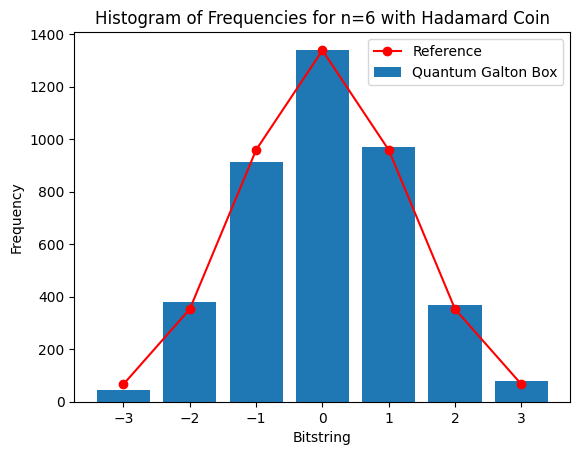

In [15]:
n = 6
left = -(n / 2)
right = left + n + 1
positions = np.arange(left, right)
mean = 0
std = np.sqrt(n)
gaussian = np.exp(-0.5 * ((2 * positions - mean) / std) ** 2)
gaussian /= gaussian.sum()
gaussian *= SHOTS

coin_function = lambda n, level: qml.Hadamard(wires=0)
freqs = run_circuit(create_qgb_circuit, n, coin_function, reverse=True)
plot_freqs(
    n,
    freqs,
    title=f"Histogram of Frequencies for n={n} with Hadamard Coin",
    x_map=list(positions),
    reference_values=gaussian,
)

Our implementation is fairly generic and allows easy introduction of custom coins that control the distribution. As an example, we could have a biased distribution with RY-rotation coin as demonstrated below.

6
<lightning.qubit device (wires=14, shots=4096) at 0x7c92f1b783b0>


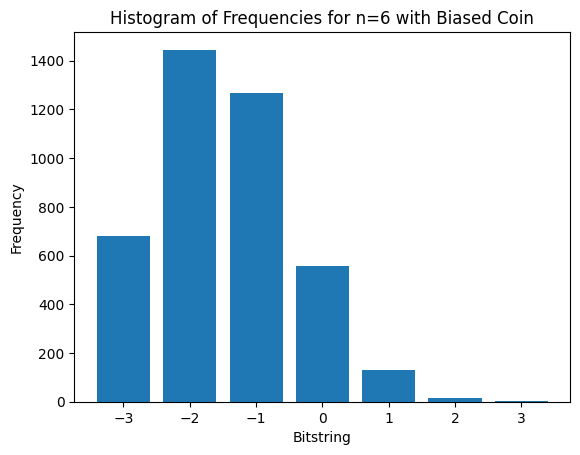

In [90]:
n = 6
left = -(n / 2)
right = left + n + 1
positions = np.arange(left, right)

coin_function = lambda n, level: qml.RY(2 * np.pi / 3, 0)

freqs = run_circuit(create_qgb_circuit, n, coin_function, reverse=True)

plot_freqs(
    n,
    freqs,
    x_map=list(positions),
    title=f"Histogram of Frequencies for n={n} with Biased Coin",
)

## Part III - Modified Target Distributions

As mentioned in Part II, we are able to introduce different coins in order to modify the output distribution of our Quantum Galton Box. In this part, we will generate Exponential Distribution and Hadamard Quantum Walk.

### Exponential Distribution

Let's now create an exponential coin that modifies the righmost peg on each level. We will condition its rotation on the appropriate qubit for each level.

In [91]:
def exponential_coin(n, level):
    """Applies an exponential coin rotation based on the level."""
    theta = 2 * math.acos(np.sqrt(1 / np.e))
    if level == 1:
        qml.RY(theta, wires=0)
    else:
        middle = n + 1
        for i in range(middle - level + 1, middle + level - 1):
            qml.CNOT(wires=[i, 0])
        qml.CRY(theta, wires=[middle + level - 1, 0])

6
<lightning.qubit device (wires=14, shots=4096) at 0x7c92f1567500>


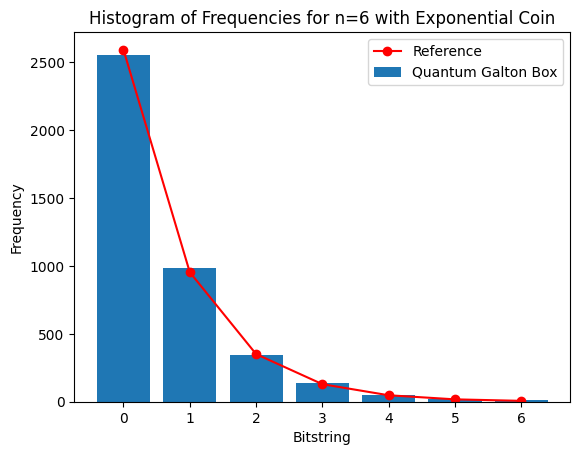

In [ ]:
n = 7

x = np.arange(0, n + 1)
lambda_rate = 1
reference_freqs = np.exp(-lambda_rate * x)
reference_freqs /= reference_freqs.sum()
reference_freqs *= SHOTS

freqs = run_circuit(create_qgb_circuit, n, exponential_coin, reverse=True)
plot_freqs(
    n,
    freqs,
    title=f"Histogram of Frequencies for n={n} with Exponential Coin",
    x_map=list(x),
    reference_values=reference_freqs,
)

In [93]:
# circuit = create_qgb_circuit(3, coin=exponential_coin)
# qml.draw_mpl(circuit, show_all_wires=True)()

### Hadamard Quantum Walk

We modify the QGB circuit to simultaneously shift the ball left and right (controlled by the coin state). It removes the need to apply CNOT between the controlled-SWAP operations, but we now have to control it both on 0 and 1 values of the coin.

In [114]:
def create_hrw_qgb_circuit(n, get_device_function, coin):
    """Creates a quantum circuit for the n-steps Hadamard Walk distribution
    leveraging the Quantum Galton Board (QGB) with n levels."""

    dev = get_device_function(n)

    def qpegs(wire_tuples, level):
        control_value = 1
        for wires in wire_tuples:
            qml.ctrl(qml.SWAP, control=0, control_values=control_value)(wires=wires)
            control_value ^= 1
            # if i < len(wire_tuples) - 1:
            #    qml.CNOT(wires=[wires[1], 0])

    @qml.qnode(dev)
    def qgb_circuit():
        qml.X(wires=n + 1)
        for level in range(1, n + 1):
            coin(n, level)
            qpegs(calculate_wire_tuples(n, level), level)
            #if level < n:
            #    qml.measure(wires=0, reset=True)
        return qml.sample(wires=range(1, 2 * n + 2, 2))

    return qgb_circuit

In [115]:
def hadamard_coin(n, level):
    """Applies a Hadamard coin rotation based on the level."""
    qml.Hadamard(wires=0)

In [116]:
def reference_hadamard_distribution(num_steps):
    hadamard = lambda: np.array([[1, 1], [1, -1]]) / np.sqrt(2)

    position_range = 2 * num_steps + 1
    mid = position_range // 2
    state = np.zeros((2, position_range), dtype=complex)
    state[:, mid] = np.array([0, 1])
    H = hadamard()
    for _ in range(num_steps):
        coin_transformed = np.zeros_like(state, dtype=complex)
        for pos in range(position_range):
            coin_state = state[:, pos]
            coin_transformed[:, pos] = H @ coin_state
        new_state = np.zeros_like(state, dtype=complex)
        for pos in range(position_range):
            for coin in [0, 1]:
                shift = -1 if coin == 0 else 1
                new_pos = pos + shift
                if 0 <= new_pos < position_range:
                    new_state[coin, new_pos] += coin_transformed[coin, pos]
        state = new_state
    total_prob = np.sum(np.abs(state) ** 2)
    probabilities = np.sum(np.abs(state) ** 2, axis=0) / total_prob
    positions = np.arange(-num_steps, num_steps + 1)
    return positions, probabilities

12


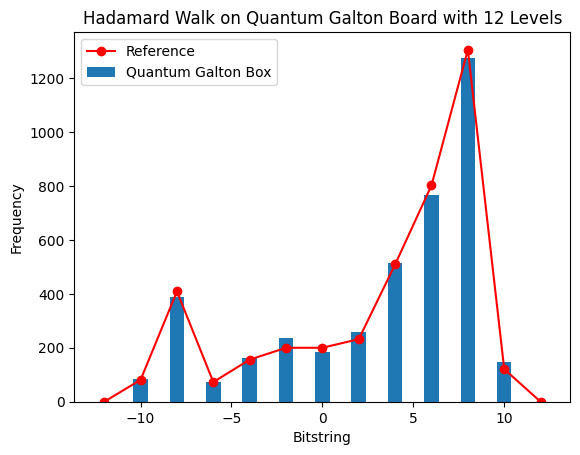

In [122]:
n = 12
freqs = run_circuit(create_hrw_qgb_circuit, n, hadamard_coin, reverse=True)
positions, reference_probs = reference_hadamard_distribution(n)
reference_freqs = [int(rf) for rf in reference_probs[::2] * SHOTS]
plot_freqs(
    n,
    freqs,
    title=f"Hadamard Walk on Quantum Galton Board with {n} Levels",
    x_map=list(positions[::2]),
    reference_values=reference_freqs,
)

## Part IV - Optimization under Noise Models

Having our implementation working on the noiseless simulators, we will now work on exploring the circuit under a noise model.

Pennylane allows loading noise models from Qiskit's IBM backends. We will use this feature to assist in the effort of optimizing the circuits (maximazing the accuracy and number of Galton board layers).

In [ ]:
from qiskit_aer.noise import NoiseModel
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_ibm_runtime.fake_provider import FakeWashingtonV2
from qiskit_ibm_runtime.fake_provider import FakeMumbaiV2, FakeBrooklynV2

backend = FakeWashingtonV2()
noise_model = NoiseModel.from_backend(backend)
print("Qiskit Noise Model:\n", noise_model)

get_noisy_dev = lambda nq: qml.device(
    "qiskit.aer", wires=2 * nq + 2, shots=SHOTS, noise_model=noise_model
)
get_noisy_dev_with_reset = lambda nq: qml.device(
    "qiskit.aer", wires=2 * nq + 2 + nq - 1, shots=SHOTS, noise_model=noise_model
)

Qiskit Noise Model:
 NoiseModel:
  Basis gates: ['cx', 'delay', 'id', 'measure', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['id', 'x', 'measure', 'cx', 'reset', 'sx']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('id', (7,)), ('id', (8,)), ('id', (9,)), ('id', (10,)), ('id', (11,)), ('id', (12,)), ('id', (13,)), ('id', (14,)), ('id', (15,)), ('id', (16,)), ('id

### Exponential Distribution

In [19]:
# Classiq implementation
# repeat(q.len, lambda i: RY(2.0 * atan(exp((-rate * 2.0**i) / 2.0)), q[i]))
n = 5
dev = qml.device("lightning.qubit", wires=n, shots=8192)
@qml.qnode(get_device(n))
def prep_exponential(rate):
    for i in range(n):
        qml.RY(2.0 * math.atan(math.exp((-rate * 2.0**i) / 2.0)), wires=i)
    return qml.sample(wires=range(n))

In [20]:
samples = prep_exponential(1.0)
bitstrings = ["".join(str(bit) for bit in sample) for sample in samples]
bitstrings = [bitstring for bitstring in bitstrings if bitstring.count("1") == 1]
freqs = Counter(bitstrings)
freqs

Counter({'10000': 937, '01000': 350, '00100': 49, '00010': 1})

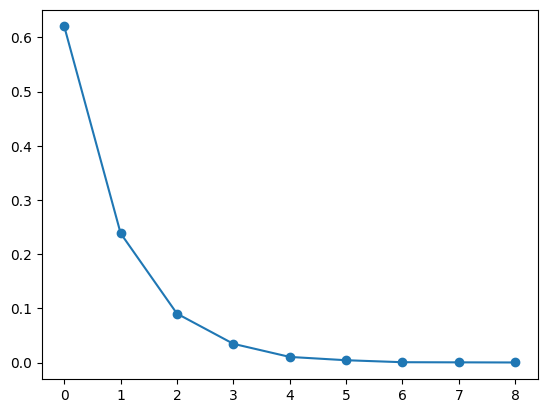

In [11]:
probs = [p for p in prep_exponential(1.0) if p > 0.00001]
probs.sort(reverse=True)
plt.plot(probs, marker='o')
plt.show()

5
<LegacyDeviceFacade: <AerDevice device (wires=16, shots=4096) at 0x7c936eb47470>>


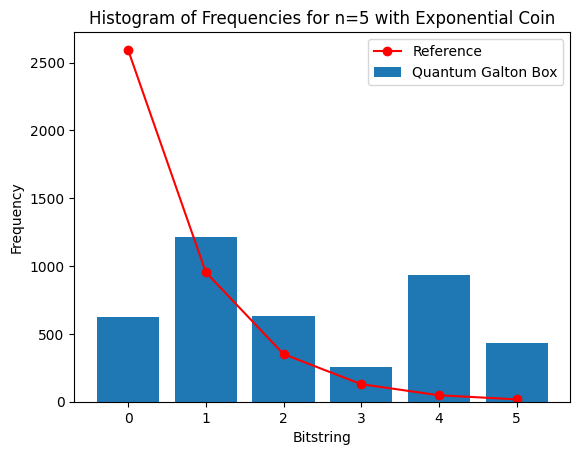

In [61]:
n = 5
x = np.arange(0, n + 1)
lambda_rate = 1
reference_freqs = np.exp(-lambda_rate * x)
reference_freqs /= reference_freqs.sum()
reference_freqs *= SHOTS
freqs = run_circuit(
    create_qgb_circuit,
    n,
    exponential_coin,
    get_device_function=get_noisy_dev_with_reset,
    reverse=True,
)
plot_freqs(
    n,
    freqs,
    title=f"Histogram of Frequencies for n={n} with Exponential Coin",
    x_map=list(x),
    reference_values=reference_freqs,
)

In [ ]:
circuit = create_qgb_circuit(n, get_device_function=get_noisy_dev, coin=exponential_coin)
qml.draw_mpl(circuit, show_all_wires=True)()

### Hadamard Random Walk

In [ ]:
n = 5
freqs = run_circuit(create_hrw_qgb_circuit, n, hadamard_coin, get_device_function=get_noisy_dev, reverse=True)
positions, reference_probs = reference_hadamard_distribution(n)
reference_freqs = [int(rf) for rf in reference_probs[::2] * SHOTS]
plot_freqs(
    n,
    freqs,
    title=f"Hadamard Walk on Quantum Galton Board with {n} Levels",
    x_map=list(positions[::2]),
    reference_values=reference_freqs,
)

In [ ]:
circuit = create_hrw_qgb_circuit(n, get_device_function=get_noisy_dev, coin=hadamard_coin)
qml.draw_mpl(circuit, show_all_wires=True)()

### Running on AWS Braket

In [62]:
import pennylane as qml
from braket.devices import Devices
import json
from datetime import datetime


get_aws_sim = lambda nq: qml.device(
    "braket.aws.qubit", device_arn=Devices.Amazon.SV1, wires=2 * nq + 2, shots=SHOTS
)
get_aws_rigetti = lambda nq: qml.device(
    "braket.aws.qubit", device_arn=Devices.Rigetti.Ankaa3, wires=2 * nq + 2, shots=SHOTS
)
get_aws_sim_with_reset = lambda nq: qml.device(
    "braket.aws.qubit",
    device_arn=Devices.Amazon.SV1,
    wires=2 * nq + 2 + nq - 1,
    shots=SHOTS,
)
get_aws_rigetti_with_reset = lambda nq: qml.device(
    "braket.aws.qubit",
    device_arn=Devices.Rigetti.Ankaa3,
    wires=2 * nq + 2 + nq - 1,
    shots=SHOTS,
)

In [63]:
def save_run(prefix, n, freqs, shots):
    rigetti_run = {
        "n": n,
        "freqs": freqs,
        "shots": shots,
    }
    with open(
        f"{prefix}_rigetti_{n}_qubits_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json",
        "w",
    ) as f:
        json.dump(rigetti_run, f, indent=4)

#### Hadamard Random Walk

In [79]:
def create_hrw_qgb_aws_circuit(n, get_device_function, coin):
    """Creates a quantum circuit for the n-steps Hadamard Walk distribution
    leveraging the Quantum Galton Board (QGB) with n levels."""

    dev = get_device_function(n)

    def qpegs(wire_tuples, level):
        control_value = 1
        for wires in wire_tuples:
            qml.ctrl(qml.SWAP, control=0, control_values=control_value)(wires=wires)
            control_value ^= 1
            # if i < len(wire_tuples) - 1:
            #    qml.CNOT(wires=[wires[1], 0])

    @qml.qnode(dev)
    def qgb_circuit():
        qml.X(wires=n + 1)
        for level in range(1, n + 1):
            coin(n, level)
            qpegs(calculate_wire_tuples(n, level), level)
            # if level < n:
            #    qml.measure(wires=0, reset=True)
        return qml.probs(wires=range(1, 2 * n + 2, 2))

    return qgb_circuit

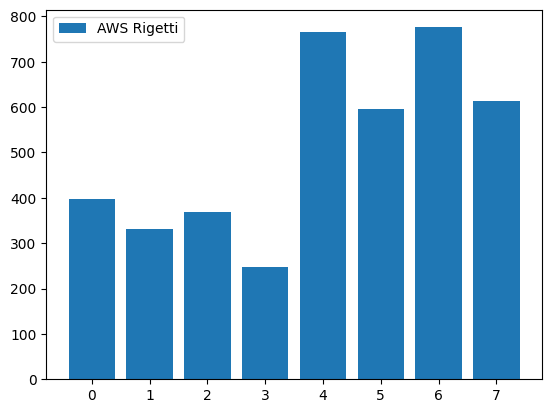

In [81]:
n = 2
aws_circuit = create_hrw_qgb_aws_circuit(
    n, get_device_function=get_aws_rigetti, coin=hadamard_coin
)
probs = aws_circuit()
freqs = {i: freq for i, freq in enumerate(reversed([p * SHOTS for p in probs]))}
plt.bar(freqs.keys(), freqs.values(), label="AWS Rigetti")
plt.legend()
plt.show()
# save_run("hrw", n, freqs, SHOTS)

#### Exponential Distribution

In [64]:
def create_qgb_aws_circuit(n, get_device_function, coin):
    """Creates a quantum circuit for the Quantum Galton Board (QGB) with n levels."""

    dev = get_device_function(n)
    print(dev)

    def qpegs(wire_tuples):
        for i, wires in enumerate(wire_tuples):
            qml.CSWAP(wires=[0, wires[0], wires[1]])
            if i < len(wire_tuples) - 1:
                qml.CNOT(wires=[wires[1], 0])

    @qml.qnode(dev)
    def qgb_circuit():
        qml.X(wires=n + 1)
        for level in range(1, n + 1):
            coin(n, level)
            qpegs(wire_tuples=calculate_wire_tuples(n, level))
            if level < n:
                qml.measure(wires=0, reset=True)
        return qml.probs(wires=range(1, 2 * n + 2, 2))

    return qgb_circuit

<LegacyDeviceFacade: <BraketAwsQubitDevice device (wires=7, shots=4096) at 0x7c937c3cab10>>


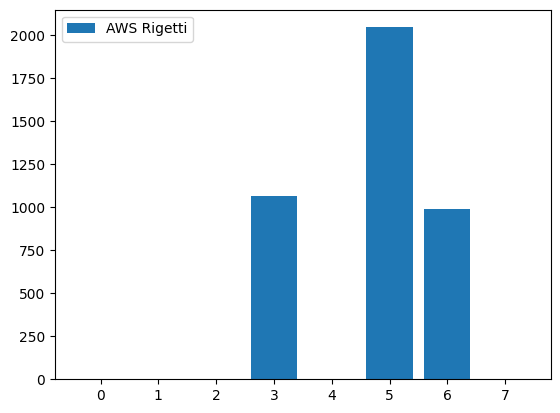

In [78]:
n = 2
aws_circuit = create_qgb_aws_circuit(
    n, get_device_function=get_aws_sim_with_reset, coin=hadamard_coin
)
probs = aws_circuit()
freqs = {i: freq for i, freq in enumerate(reversed([p * SHOTS for p in probs]))}
plt.bar(freqs.keys(), freqs.values(), label="AWS Rigetti")
plt.legend()
plt.show()
# save_run("exp", n, freqs, SHOTS)

## Part V - Study the Distances between Obtained and Target Distributions

Let's now turn to understanding how well the obtained distributions are approximating the target distributions.

We have collected a hefty amount of samples for both Exponential and Hadamard Random Walk circuits executed under the noise model.

In [ ]:
from qiskit_ibm_runtime.fake_provider import FakeWashingtonV2
fw = FakeWashingtonV2()
noise_model = NoiseModel.from_backend(fw)

In [ ]:
fw.num_qubits